In [0]:
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.colors as mcolors

import operator 
import random

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error as mse_loss

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [118]:
%cd /content/drive/My Drive/Colab Notebooks/corona

/content/drive/My Drive/Colab Notebooks/corona


In [0]:
data=pd.read_csv('confirmed.csv')

In [120]:
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3


In [121]:
data.describe()

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
count,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000
mean,21.845749,25.421757,2.265306,2.669388,3.840816,5.853061,8.644898,11.946939,22.767347,25.167347,33.608163,40.518367,49.134694,68.518367,81.146939,97.518367,112.795918,125.689796,140.371429,151.510204,163.877551,174.538776,182.865306,184.575510,246.400000,273.000000,281.755102,290.710204,299.012245,306.677551,308.730612,311.008163,313.546939,320.702041,322.277551,324.738776,328.187755,332.195918,337.738776,343.314286,351.065306,360.689796,368.595918,378.938776,388.244898,399.534694,415.514286,432.028571,448.248980,463.632653,484.163265,513.775510,523.885714,592.673469,637.146939,683.485714,741.118367,804.497959,876.820408,989.795918,1110.346939,1242.432653,1375.318367,1543.816327,1706.306122,1908.542857
std,24.421229,70.431613,28.421718,28.521794,35.502989,49.406590,69.040025,93.017060,228.335385,229.709672,316.564191,375.308568,461.845232,717.815605,867.759251,1069.496816,1260.341848,1416.802268,1598.290697,1735.516611,1897.089173,2030.967240,2135.579858,2135.922339,3081.922883,3477.532125,3595.218540,3718.624248,3833.972530,3942.045573,3964.349750,3990.567176,4004.676775,4095.405948,4095.435430,4108.449743,4140.342263,4166.123231,4192.799654,4214.105719,4243.083927,4281.807496,4297.247535,4310.061140,4321.899931,4336.494615,4354.316502,4372.249609,4389.225049,4409.348779,4425.894917,4460.255294,4470.850905,4567.361320,4652.015739,4750.724423,4868.468943,5008.629926,5196.710687,5498.393269,5864.902292,6309.666305,6763.993017,7393.804351,8031.186570,8883.541496
min,-41.454500,-123.120700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,7.946500,-14.452400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,4.000000,5.000000,6.000000,9.000000,10.000000,12.000000
50%,24.000000,21.745300,0.000000,0.000000,0.000000,0.000000,0.000000,

In [0]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [123]:
train=data
b=len(train)
print("total examples:",b)
for col in train.columns:
  a=train[col].isna().sum()
  c=(a/b)*100
  print(col, "has", a ,"NaN's with",c,"percentage")

total examples: 245
Province/State has 171 NaN's with 69.79591836734694 percentage
Country/Region has 0 NaN's with 0.0 percentage
Lat has 0 NaN's with 0.0 percentage
Long has 0 NaN's with 0.0 percentage
1/22/20 has 0 NaN's with 0.0 percentage
1/23/20 has 0 NaN's with 0.0 percentage
1/24/20 has 0 NaN's with 0.0 percentage
1/25/20 has 0 NaN's with 0.0 percentage
1/26/20 has 0 NaN's with 0.0 percentage
1/27/20 has 0 NaN's with 0.0 percentage
1/28/20 has 0 NaN's with 0.0 percentage
1/29/20 has 0 NaN's with 0.0 percentage
1/30/20 has 0 NaN's with 0.0 percentage
1/31/20 has 0 NaN's with 0.0 percentage
2/1/20 has 0 NaN's with 0.0 percentage
2/2/20 has 0 NaN's with 0.0 percentage
2/3/20 has 0 NaN's with 0.0 percentage
2/4/20 has 0 NaN's with 0.0 percentage
2/5/20 has 0 NaN's with 0.0 percentage
2/6/20 has 0 NaN's with 0.0 percentage
2/7/20 has 0 NaN's with 0.0 percentage
2/8/20 has 0 NaN's with 0.0 percentage
2/9/20 has 0 NaN's with 0.0 percentage
2/10/20 has 0 NaN's with 0.0 percentage
2/11/2

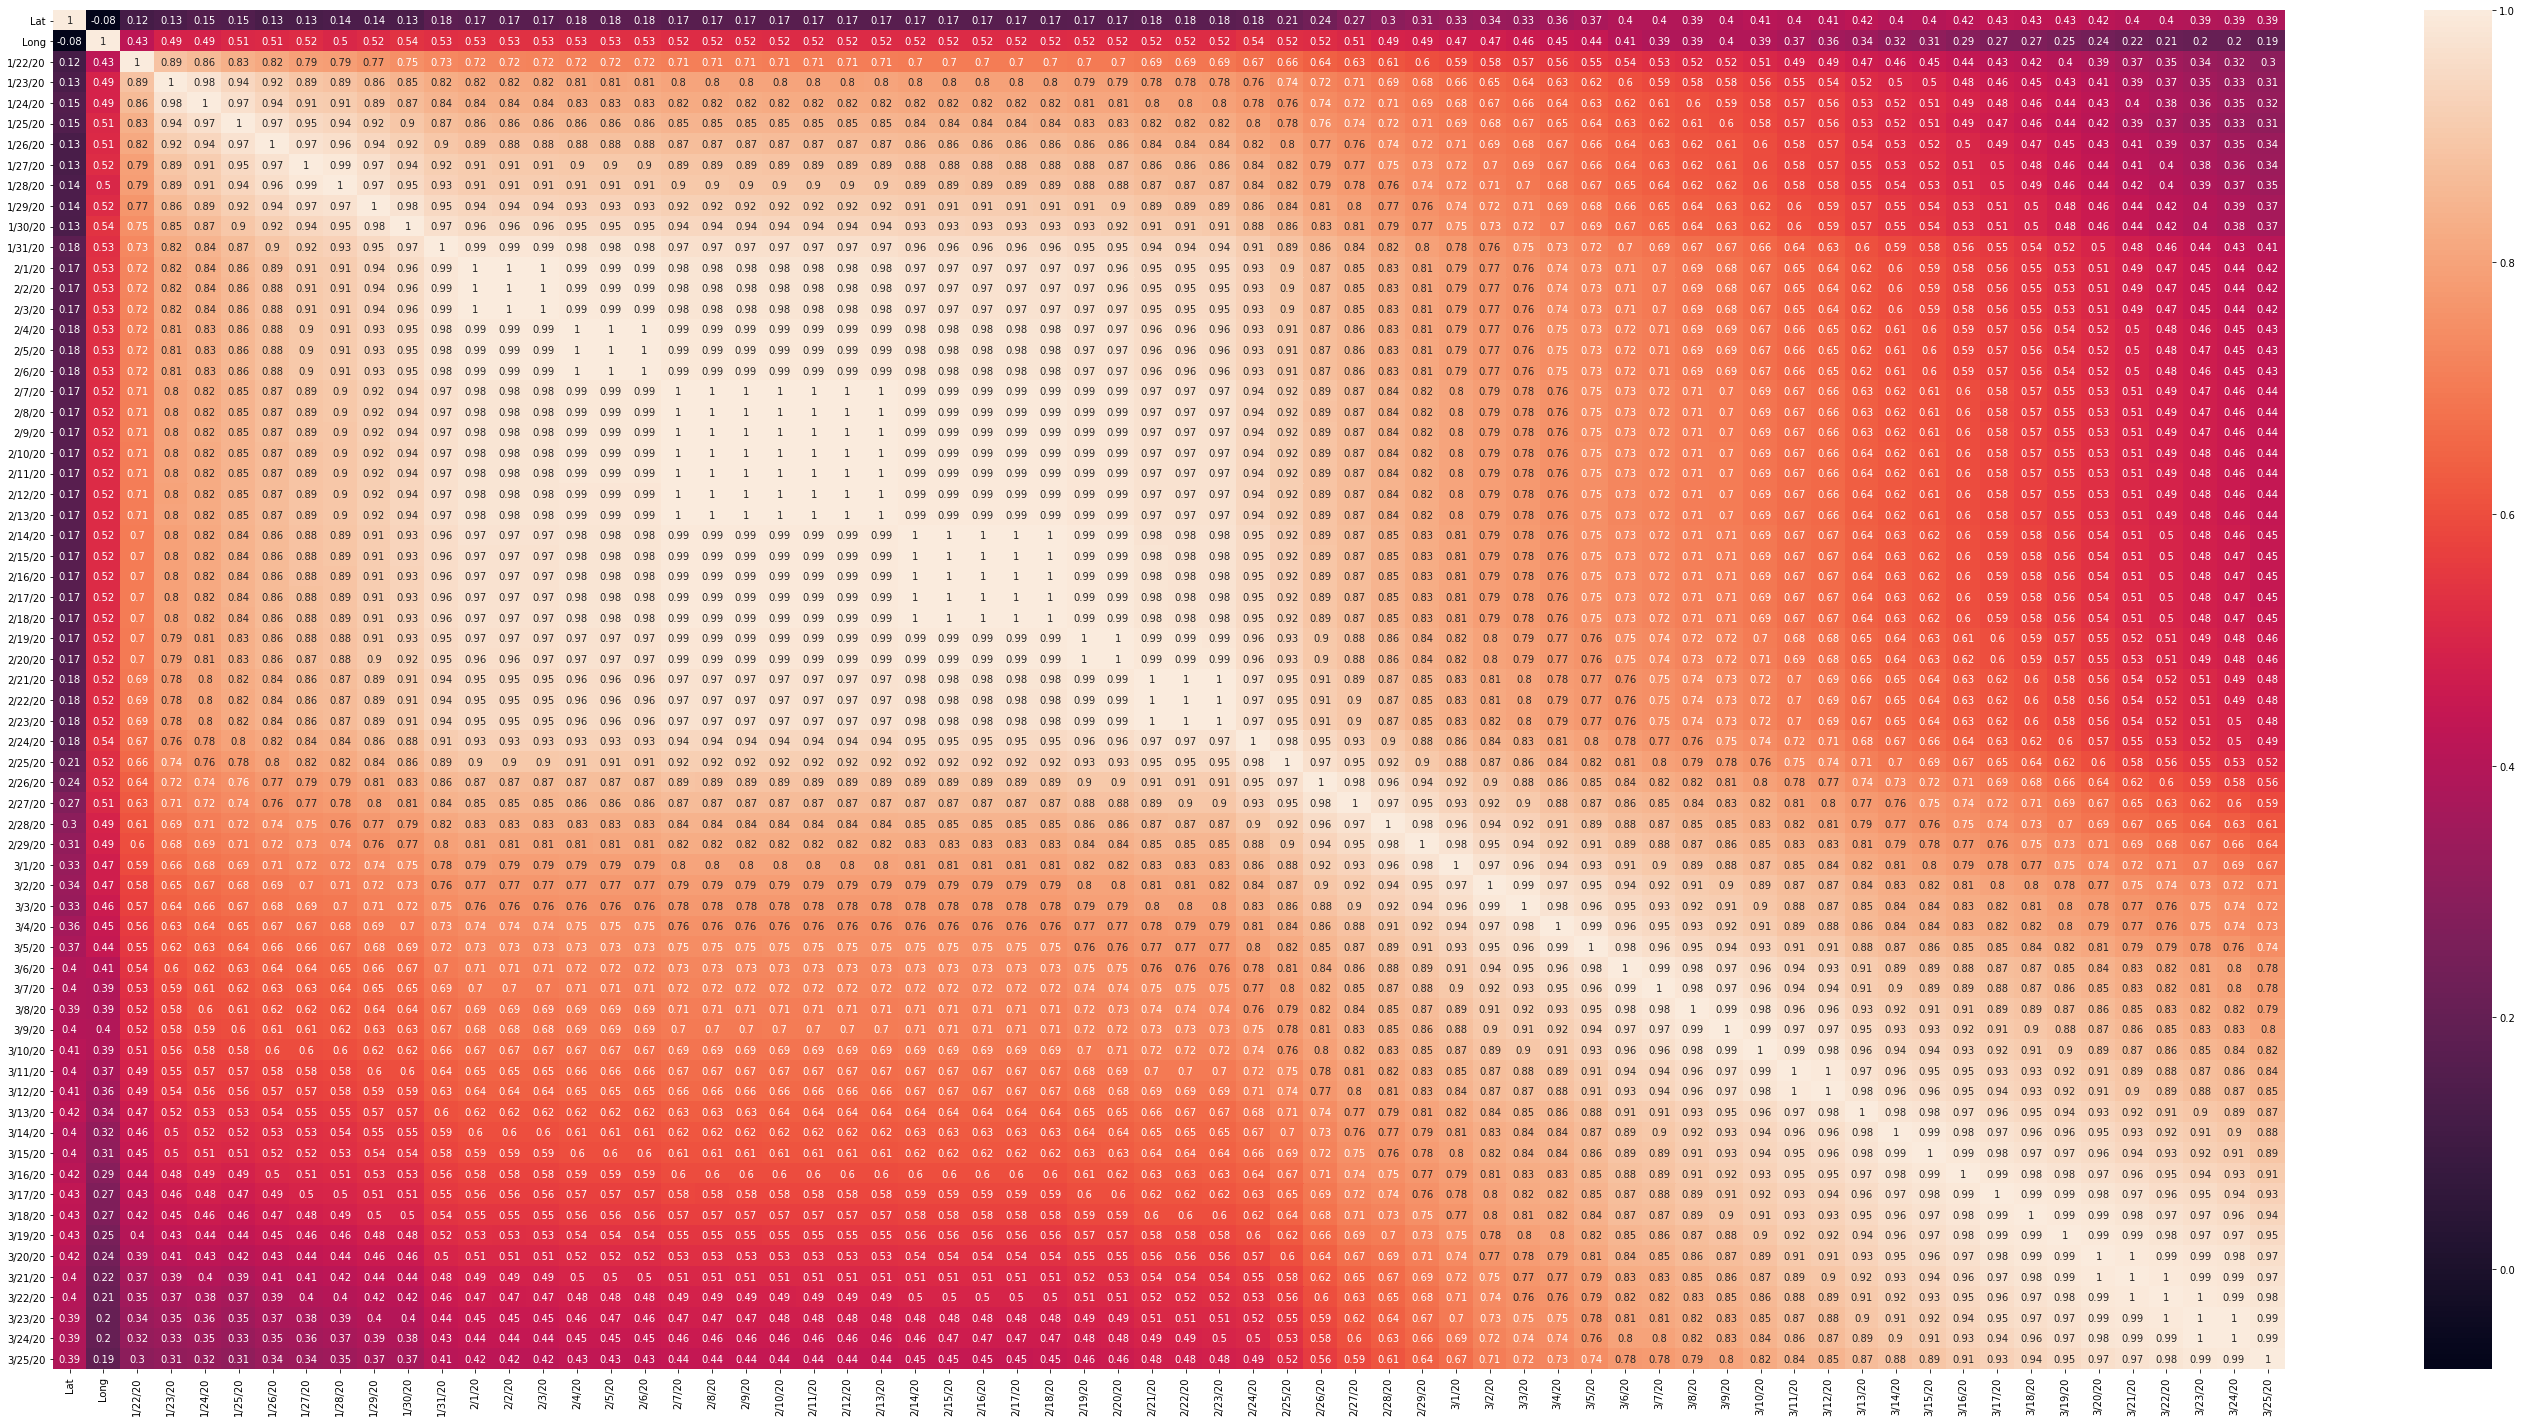

In [124]:
fig, ax = plt.subplots(figsize=(50,25))
# use a ranked correlation to catch nonlinearities
corr = train[[col for col in train.columns]].corr(method='spearman')
_ = sns.heatmap(corr, annot=True,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

In [125]:
confirmed=data
dates = confirmed.keys()
dates

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20'],
      dtype='object')

# Visualizations

In [0]:
confirmed_df=data
cols = confirmed_df.keys()
confirmed=data.loc[:, cols[4]:cols[-1]]
dates = confirmed.keys()

world_cases = []

china_cases = [] 
italy_cases = []
us_cases = [] 
india_cases= []
spain_cases = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
   
    world_cases.append(confirmed_sum)
    

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    india_cases.append(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    spain_cases.append(confirmed_df[confirmed_df['Country/Region']=='Spain'][i].sum())

In [0]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

world_daily_increase = daily_increase(world_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)
india_daily_increase = daily_increase(india_cases)

In [0]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)


In [0]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [130]:
type(world_cases)

list

In [131]:
x = []
for sublist in adjusted_dates:
    for item in sublist:
        x.append(item)

#x=adjusted_dates.tolist()
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=world_cases,mode='lines+markers',name='Confirmed cases'))
fig.update_layout(title='Coronavirus Cases Over Time',xaxis_title="Days Since 1/22/2020",
    yaxis_title="Number of cases",)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=36)
fig.show()

In [132]:
fig = go.Figure()
fig.add_trace(go.Bar(y=world_daily_increase,name='Confirmed cases'))
fig.update_layout(title='Coronavirus Cases Increasing Over Time',xaxis_title="Days Since 1/22/2020",
    yaxis_title="Number of cases",)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=36)
fig.show()

In [133]:
fig = go.Figure()
fig.add_trace(go.Bar(y=china_daily_increase,name='Confirmed cases'))
fig.update_layout(title='Coronavirus Cases Increasing Over Time in China',xaxis_title="Days Since 1/22/2020",
    yaxis_title="Number of cases",)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=36)
fig.show()

In [134]:
fig = go.Figure()
fig.add_trace(go.Bar(y=italy_daily_increase,name='Confirmed cases'))
fig.update_layout(title='Coronavirus Cases Increasing Over Time in Italy',xaxis_title="Days Since 1/22/2020",
    yaxis_title="Number of cases",)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=36)
fig.show()

In [135]:
fig = go.Figure()
fig.add_trace(go.Bar(y=us_daily_increase,name='Confirmed cases'))
fig.update_layout(title='Coronavirus Cases Increasing Over Time in US',xaxis_title="Days Since 1/22/2020",
    yaxis_title="Number of cases",)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=36)
fig.show()

In [136]:
fig = go.Figure()
fig.add_trace(go.Bar(y=spain_daily_increase,name='Confirmed cases'))
fig.update_layout(title='Coronavirus Cases Increasing Over Time in Spain',xaxis_title="Days Since 1/22/2020",
    yaxis_title="Number of cases",)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=36)
fig.show()

In [137]:
fig = go.Figure()
fig.add_trace(go.Bar(y=india_daily_increase,name='Confirmed cases'))
fig.update_layout(title='Coronavirus Cases Increasing Over Time in India',xaxis_title="Days Since 1/22/2020",
    yaxis_title="Number of cases",)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=36)
fig.show()

In [138]:
#x=adjusted_dates.tolist()
fig = go.Figure()


fig.add_trace(go.Scatter(x=x, y=india_cases,mode='lines+markers',name="India's cases"))


fig.update_layout(title='Coronavirus Cases Over Time In India',xaxis_title="Days Since 1/22/2020",
    yaxis_title="Number of cases",)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=36)
fig.show()

In [139]:
#x=adjusted_dates.tolist()
fig = go.Figure()

#fig.add_trace(go.Scatter(x=x, y=world_cases,mode='lines+markers',name='Totla cases'))
fig.add_trace(go.Scatter(x=x, y=china_cases,mode='lines+markers',name="China's cases"))
fig.add_trace(go.Scatter(x=x, y=india_cases,mode='lines+markers',name="India's cases"))
fig.add_trace(go.Scatter(x=x, y=us_cases,mode='lines+markers',name="USA's cases"))
fig.add_trace(go.Scatter(x=x, y=italy_cases,mode='lines+markers',name="Italy's cases"))
fig.add_trace(go.Scatter(x=x, y=spain_cases,mode='lines+markers',name="Spain's cases"))

fig.update_layout(title='Coronavirus Cases Over Time',xaxis_title="Days Since 1/22/2020",
    yaxis_title="Number of cases",)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=36)
fig.show()

In [140]:
#x=adjusted_dates.tolist()
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=world_cases,mode='lines+markers',name='Total cases'))
fig.add_trace(go.Scatter(x=x, y=china_cases,mode='lines+markers',name="China's cases"))
fig.add_trace(go.Scatter(x=x, y=india_cases,mode='lines+markers',name="India's cases"))
fig.add_trace(go.Scatter(x=x, y=us_cases,mode='lines+markers',name="USA's cases"))
fig.add_trace(go.Scatter(x=x, y=italy_cases,mode='lines+markers',name="Italy's cases"))
fig.add_trace(go.Scatter(x=x, y=spain_cases,mode='lines+markers',name="Spain's cases"))

fig.update_layout(title='Coronavirus Cases Over Time',xaxis_title="Days Since 1/22/2020",
    yaxis_title="Number of cases",)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=36)
fig.show()

In [0]:
unique_countries =  list(confirmed_df['Country/Region'].unique())
country_confirmed_cases = []
latest_confirmed = confirmed_df[dates[-1]]
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmed_df['Country/Region']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_confirmed[confirmed_df['Country/Region']==unique_countries[i]].sum()

In [142]:
# number of cases per country/region
print('Confirmed Cases by Countries/Regions:')
for i in range(len(unique_countries)):
    print(f'{unique_countries[i]}: {country_confirmed_cases[i]} cases')

Confirmed Cases by Countries/Regions:
China: 81661 cases
Italy: 74386 cases
US: 65778 cases
Spain: 49515 cases
Germany: 37323 cases
Iran: 27017 cases
France: 25600 cases
Switzerland: 10897 cases
United Kingdom: 9640 cases
Korea, South: 9137 cases
Netherlands: 6438 cases
Austria: 5588 cases
Belgium: 4937 cases
Canada: 3251 cases
Norway: 3084 cases
Portugal: 2995 cases
Brazil: 2554 cases
Sweden: 2526 cases
Turkey: 2433 cases
Israel: 2369 cases
Australia: 2364 cases
Denmark: 1862 cases
Malaysia: 1796 cases
Czechia: 1654 cases
Ireland: 1564 cases
Luxembourg: 1333 cases
Japan: 1307 cases
Ecuador: 1173 cases
Chile: 1142 cases
Pakistan: 1063 cases
Poland: 1051 cases
Thailand: 934 cases
Romania: 906 cases
Saudi Arabia: 900 cases
Finland: 880 cases
Greece: 821 cases
Indonesia: 790 cases
Iceland: 737 cases
Diamond Princess: 712 cases
South Africa: 709 cases
Russia: 658 cases
India: 657 cases
Philippines: 636 cases
Singapore: 631 cases
Qatar: 537 cases
Slovenia: 528 cases
Peru: 480 cases
Colombia

In [0]:
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

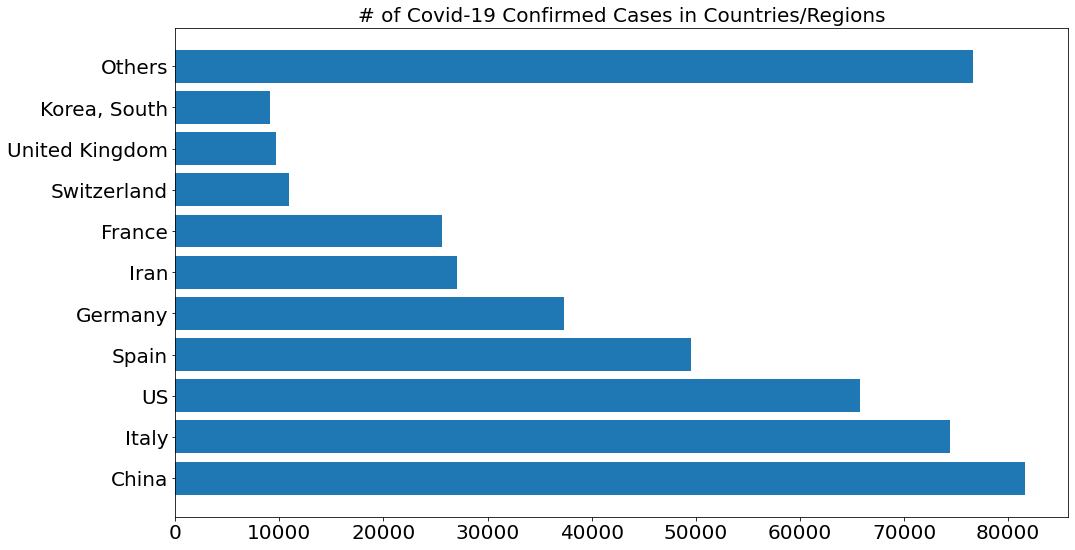

In [144]:
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

#Predictions

In [0]:
full_table = confirmed_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed")

full_table['Date'] = pd.to_datetime(full_table['Date'])
full_table.head()

In [0]:
len(full_table)

In [0]:
full_table.head()

In [0]:
data=full_table.drop(['Lat','Long'],axis=1)

In [0]:
data['days']=(data['Date']-pd.to_datetime("2020-01-22")).dt.days

In [390]:
data.tail()

,Province/State,Country/Region,Date,Confirmed,days
15675,NaN,Libya,2020-03-25,1,63
15676,NaN,West Bank and Gaza,2020-03-25,-1,63
15677,NaN,Guinea-Bissau,2020-03-25,2,63
15678,NaN,Mali,2020-03-25,2,63
15679,NaN,Saint Kitts and Nevis,2020-03-25,2,63


In [391]:
data['Confirmed'].max()

74386

In [0]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
le2 = LabelEncoder()

In [0]:
categoricals=["Province/State", 	"Country/Region"]
numericals=["days"]

In [394]:
data.fillna(value="no",inplace=True)
data.tail()

,Province/State,Country/Region,Date,Confirmed,days
15675,no,Libya,2020-03-25,1,63
15676,no,West Bank and Gaza,2020-03-25,-1,63
15677,no,Guinea-Bissau,2020-03-25,2,63
15678,no,Mali,2020-03-25,2,63
15679,no,Saint Kitts and Nevis,2020-03-25,2,63


In [0]:
data["Province/State"]=le1.fit_transform(data["Province/State"])
data["Country/Region"]=le2.fit_transform(data["Country/Region"])

In [396]:
data.tail()

,Province/State,Country/Region,Date,Confirmed,days
15675,74,94,2020-03-25,1,63
15676,74,171,2020-03-25,-1,63
15677,74,68,2020-03-25,2,63
15678,74,101,2020-03-25,2,63
15679,74,134,2020-03-25,2,63


In [0]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()

In [0]:
data[["Confirmed"]]=scaler1.fit_transform(data[["Confirmed"]].to_numpy())


In [0]:
data[["days"]]=scaler2.fit_transform(data[["days"]].to_numpy())

In [401]:
data=data.drop("Date",axis=1)
data.head()

,Province/State,Country/Region,Confirmed,days
0,74,0,-0.103276,-1.705196
1,74,1,-0.103276,-1.705196
2,74,2,-0.103276,-1.705196
3,74,3,-0.103276,-1.705196
4,74,4,-0.103276,-1.705196


In [402]:
data, NAlist = reduce_mem_usage(data)
data.head()

Memory usage of properties dataframe is : 0.4786376953125  MB
******************************
Column:  Province/State
dtype before:  int64
min for this col:  0
max for this col:  74
dtype after:  uint8
******************************
******************************
Column:  Country/Region
dtype before:  int64
min for this col:  0
max for this col:  173
dtype after:  uint8
******************************
******************************
Column:  Confirmed
dtype before:  float64
min for this col:  -0.10352698192375895
max for this col:  18.541389553432015
dtype after:  float32
******************************
******************************
Column:  days
dtype before:  float64
min for this col:  -1.7051956801764152
max for this col:  1.7051956801764152
dtype after:  int8
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.10479736328125  MB
This is  21.894924764090792 % of the initial size


,Province/State,Country/Region,Confirmed,days
0,74,0,-0.103276,-1
1,74,1,-0.103276,-1
2,74,2,-0.103276,-1
3,74,3,-0.103276,-1
4,74,4,-0.103276,-1


In [0]:
val=data[data.days>61]
train=data[data.days<62]

In [404]:
train.head()

,Province/State,Country/Region,Confirmed,days
0,74,0,-0.103276,-1
1,74,1,-0.103276,-1
2,74,2,-0.103276,-1
3,74,3,-0.103276,-1
4,74,4,-0.103276,-1


In [405]:
train.describe()

,Province/State,Country/Region,Confirmed,days
count,15680.000000,15680.000000,15680.000000,15680.000000
mean,62.673469,75.334694,0.000002,0.000000
std,20.839588,50.876922,1.000045,0.661459
min,0.000000,0.000000,-0.103527,-1.000000
25%,61.000000,33.000000,-0.103276,0.000000
50%,74.000000,60.000000,-0.103276,0.000000
75%,74.000000,118.000000,-0.098765,0.000000
max,74.000000,173.000000,18.541389,1.000000


In [0]:
def model(dense_dim_1=16, dense_dim_2=8, dense_dim_3=8, dense_dim_4=4, 
dropout1=0.4, dropout2=0.3, dropout3=0.3, dropout4=0.4, lr=0.0005,pre_model=None):

    #Inputs
    state = Input(shape=[1], name="Province/State")
    country = Input(shape=[1], name="Country/Region")
    #conf = Input(shape=[1], name="Confirmed")
    days = Input(shape=[1], name="days")
    
   
    #Embeddings layers
    emb_state = Embedding(75, 4)(state)
    emb_country = Embedding(174, 4)(country)
    

    concat_emb = concatenate([
           Flatten() (emb_state)
         , Flatten() (emb_country)
         
    ])
    
    categ = Dropout(dropout1)(Dense(dense_dim_1,activation='relu') (concat_emb))
    categ = BatchNormalization()(categ)
    #categ = Dropout(dropout2)(Dense(dense_dim_2,activation='relu') (categ))
    
    #main layer
    main_l = concatenate([
          categ
        , days
        
    ])
    
    main_l = Dropout(dropout3)(Dense(dense_dim_3,activation='relu') (main_l))
    main_l = BatchNormalization()(main_l)
    #main_l = Dropout(dropout4)(Dense(dense_dim_4,activation='relu') (main_l))
    
    #output
    output = Dense(1) (main_l)

    model = Model([ state,
                    country, 
                    days], output)

    model.compile(optimizer = Adam(lr=lr),
                  loss= mse_loss,
                  metrics=[root_mean_squared_error,"accuracy"])
    return model

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))

In [0]:
def get_keras_data(df, num_cols, cat_cols):
    cols = num_cols + cat_cols
    X = {col: np.array(df[col]) for col in cols}
    return X

In [0]:
Y_train=train.Confirmed
X_train=train.drop('Confirmed',axis=1)
Y_valid=val.Confirmed
X_valid=val.drop("Confirmed",axis=1)

In [0]:
X_t = get_keras_data(X_train, numericals, categoricals)
X_v = get_keras_data(X_valid, numericals, categoricals)

In [0]:
keras_model=model(lr=0.001)

In [0]:
early_stopping = EarlyStopping(patience=105, verbose=2)
model_checkpoint = ModelCheckpoint("corona.hdf5",#Changed
                                       save_best_only=True, verbose=2, monitor='val_root_mean_squared_error', mode='min')
hist = keras_model.fit(X_t, Y_train, batch_size=256, epochs=300,
                            validation_data=None, validation_split=0.15,
                            callbacks=[early_stopping, model_checkpoint])

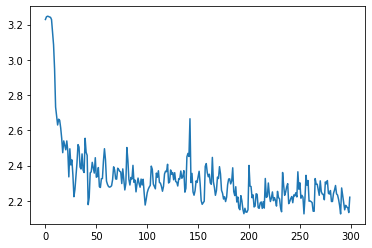

In [331]:
plt.plot(hist.history['val_loss'])

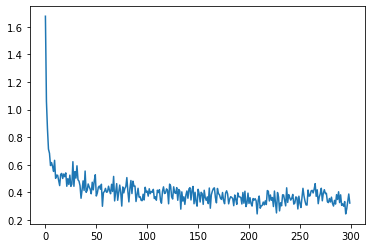

In [332]:
plt.plot(hist.history['loss'])

In [0]:
Modl=load_model("corona.hdf5",custom_objects={'root_mean_squared_error': root_mean_squared_error})

In [335]:
sub=pd.read_csv('submission.csv')
sub=sub.melt(id_vars=["Province/State", "Country/Region"], var_name="Date", value_name="Confirmed")
sub['Date'] = pd.to_datetime(sub['Date'])
sub.head()

,Province/State,Country/Region,Date,Confirmed
0,NaN,Afghanistan,2020-03-28,NaN
1,NaN,Albania,2020-03-28,NaN
2,NaN,Algeria,2020-03-28,NaN
3,NaN,Andorra,2020-03-28,NaN
4,NaN,Angola,2020-03-28,NaN


In [0]:
sub["Province/State"].fillna(value="no",inplace=True)

sub["Province/State"]=le1.transform(sub["Province/State"])
sub["Country/Region"]=le2.transform(sub["Country/Region"])

In [0]:
sub['days']=(sub['Date']-pd.to_datetime("2020-01-22")).dt.days

In [0]:
sub[["days"]]=scaler2.transform(sub[["days"]].to_numpy())

In [346]:
sub.head()

,Province/State,Country/Region,Date,Confirmed,days
0,74,0,2020-03-28,NaN,1.867595
1,74,1,2020-03-28,NaN,1.867595
2,74,2,2020-03-28,NaN,1.867595
3,74,3,2020-03-28,NaN,1.867595
4,74,4,2020-03-28,NaN,1.867595


In [347]:
len(sub)

1715

In [0]:
for_prediction=get_keras_data(sub,numericals,categoricals)


In [0]:
result=Modl.predict(for_prediction, batch_size=1715)

In [0]:
sub['Confirmed']=result

In [0]:
sub['Confirmed']=scaler1.inverse_transform(sub['Confirmed'])

In [353]:
sub.head()

,Province/State,Country/Region,Date,Confirmed,days
0,74,0,2020-03-28,282.236206,1.867595
1,74,1,2020-03-28,282.236206,1.867595
2,74,2,2020-03-28,282.236206,1.867595
3,74,3,2020-03-28,282.236206,1.867595
4,74,4,2020-03-28,282.236206,1.867595


In [355]:
sub.Confirmed.max()

55019.4609375

In [362]:
sub.describe()


,Province/State,Country/Region,Confirmed,days
count,1715.000000,1715.000000,1715.000000,1715.000000
mean,62.673469,75.334694,511.662974,2.029995
std,20.845001,50.890139,3483.608436,0.108298
min,0.000000,0.000000,282.000000,1.867595
25%,61.000000,33.000000,282.000000,1.921728
50%,74.000000,60.000000,282.000000,2.029995
75%,74.000000,118.000000,296.000000,2.138261
max,74.000000,173.000000,55019.000000,2.192394


In [0]:
sub['Confirmed']=(sub.Confirmed.astype(np.int64))

In [0]:
sub=sub.drop("days",axis=1)

In [367]:
sub.head()

,Province/State,Country/Region,Date,Confirmed
0,74,0,2020-03-28,282
1,74,1,2020-03-28,282
2,74,2,2020-03-28,282
3,74,3,2020-03-28,282
4,74,4,2020-03-28,282


In [368]:
pt=sub.set_index(["Province/State", "Country/Region", 'Date']).unstack('Date').reset_index()
pt.columns.name=None
pt.reset_index()

index Province/State  ...           Confirmed                    
Date                       ... 2020-04-02 00:00:00 2020-04-03 00:00:00
0        0              0  ...                 296                 315
1        1              1  ...                 296                 315
2        2              2  ...                 296                 315
3        3              3  ...                 296                 315
4        4              4  ...                 296                 315
..     ...            ...  ...                 ...                 ...
240    240             74  ...                 296                 315
241    241             74  ...                 296                 315
242    242             74  ...                 296                 315
243    243             74  ...                 296                 315
244    244             74  ...                 296                 315

[245 rows x 10 columns]

In [0]:
sub1=pd.read_csv('submission.csv')

In [0]:
pt.columns=sub1.columns

In [0]:
pt['Province/State']=le1.inverse_transform(pt['Province/State'])

In [0]:
pt['Country/Region']=le2.inverse_transform(pt['Country/Region'])

In [376]:
pt['Province/State'].value_counts()

no                  171
Macau                 1
Greenland             1
Grand Princess        1
Nova Scotia           1
                   ... 
French Polynesia      1
Alberta               1
Montserrat            1
Hebei                 1
Guizhou               1
Name: Province/State, Length: 75, dtype: int64

In [0]:
pt=pt.replace("no","")

In [382]:
len(pt)

245

In [383]:
pt.head()

,Province/State,Country/Region,3/28/20,3/29/20,3/30/20,3/31/20,04-01-2020,04-02-2020,04-03-2020
0,Alberta,Canada,282,282,282,282,282,296,315
1,Anhui,China,282,282,282,282,282,296,315
2,Aruba,Netherlands,282,282,282,282,282,296,315
3,Australian Capital Territory,Australia,282,282,282,282,282,296,315
4,Beijing,China,282,282,282,282,282,296,315


In [384]:
pt['Province/State'].value_counts()

                    171
Macau                 1
Anhui                 1
Shanxi                1
Grand Princess        1
                   ... 
French Polynesia      1
Alberta               1
Montserrat            1
Hebei                 1
Guizhou               1
Name: Province/State, Length: 75, dtype: int64

In [0]:
pt.to_csv("submit.csv")